In [828]:
import numpy as np
import librosa
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import cv2 as cv
from skimage import morphology
import skimage.filters as filters

In [829]:
PATH_0 = "../../birdclef-2022-data"
PATH_1 = "../../birdclef-2022-data"
AUDIO_PATH = f"{PATH_1}/train_audio"
IMAGE_PATH = f"{PATH_1}/train_images/"

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
SEED = 42
CLASSES = sorted(os.listdir(AUDIO_PATH))
NUM_CLASSES = len(CLASSES)
NUM_WORKERS = 4

train = pd.read_csv(f"{PATH_1}/train_metadata.csv")

In [830]:
class AudioParams:
    """
    Parameters used for the audio data
    """
    sr = 32000
    duration = 5
    length = sr * duration
    n_mels = 224
    hop_length = 512
    n_fft = 2 * hop_length
    fmin = 20
    fmax = 16000

In [831]:
# Helper functions for cropping, padding, computing of mel spectrograms

def crop_or_pad(y):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})
        probs {None or numpy array} -- Probabilities to use to chose where to crop (default: {None})
    Returns:
        1D np array -- Cropped array
    """
    start = 0
    length = len(y)
    z = []
    for _ in range(math.ceil(len(y) / AudioParams.length)):
        if length <= AudioParams.length:
            z.append(np.concatenate([y[start:], np.zeros(AudioParams.length - length)]).astype(np.float32))
        else:
            z.append(y[start: start + AudioParams.length].astype(np.float32))
            length -= AudioParams.length
            start += AudioParams.length

    return z

def compute_melspec(y, params):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = librosa.feature.melspectrogram(
        y=y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.n_fft
    )

    melspec = librosa.power_to_db(melspec).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    V = np.flip(V, axis=0)

    return V

In [832]:
# Core functions to split the already generated spectrograms into 5 sec splits

def audio_to_images(path, save_path, params):
    y, sr = sf.read(path, always_2d=True)
    y = np.mean(y, 1) # there is (X, 2) array
    y = crop_or_pad(y)
    for index, img in enumerate(y):
        image = compute_melspec(img, params)
        image = mono_to_color(image)
        image = cv.resize(image, (224, 224))
        image = image.astype(np.uint8)
        np.save(save_path + f"_{index}", image)

def save_to(path):
    save_path = IMAGE_PATH + "/".join(path.split('/')[-2:])
    save_path = save_path[:-4]
    audio_to_images(path, save_path, AudioParams)

def save_and_generate_specs():
     NUM_WORKERS = 4
     _ = Parallel(n_jobs=NUM_WORKERS)(delayed(save_to)(AUDIO_PATH) for AUDIO_PATH in tqdm(paths))

In [833]:
def median_clipping(spectrogram, number_times_larger):
    """ Compute binary image from spectrogram where cells are marked as 1 if
    number_times_larger than the row AND column median, otherwise 0
    """
    row_medians = np.median(spectrogram, axis=1)/5
    col_medians = np.median(spectrogram, axis=0)/10

    # create 2-d array where each cell contains row median
    row_medians_cond = np.tile(row_medians, (spectrogram.shape[1], 1)).transpose()
    # create 2-d array where each cell contains column median
    col_medians_cond = np.tile(col_medians, (spectrogram.shape[0], 1))

    # find cells number_times_larger than row and column median
    larger_row_median = spectrogram >= row_medians_cond*number_times_larger
    larger_col_median = spectrogram >= col_medians_cond*number_times_larger

    # create binary image with cells number_times_larger row AND col median
    binary_image = np.logical_and(larger_row_median, larger_col_median)
    return binary_image

In [834]:
def smooth_mask(mask):
    """ Smooths a binary mask using 4x4 dilation
        # Arguments
            mask : the binary mask
        # Returns
            mask : a smoother binary mask
    """
    n_hood = np.ones(4)
    mask = morphology.binary_dilation(mask, n_hood)

    # type casting is a bitch
    return mask

In [835]:
paths = AUDIO_PATH + '/' + train['filename']
paths = paths.values
#save_and_generate_specs()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<Figure size 640x480 with 0 Axes>

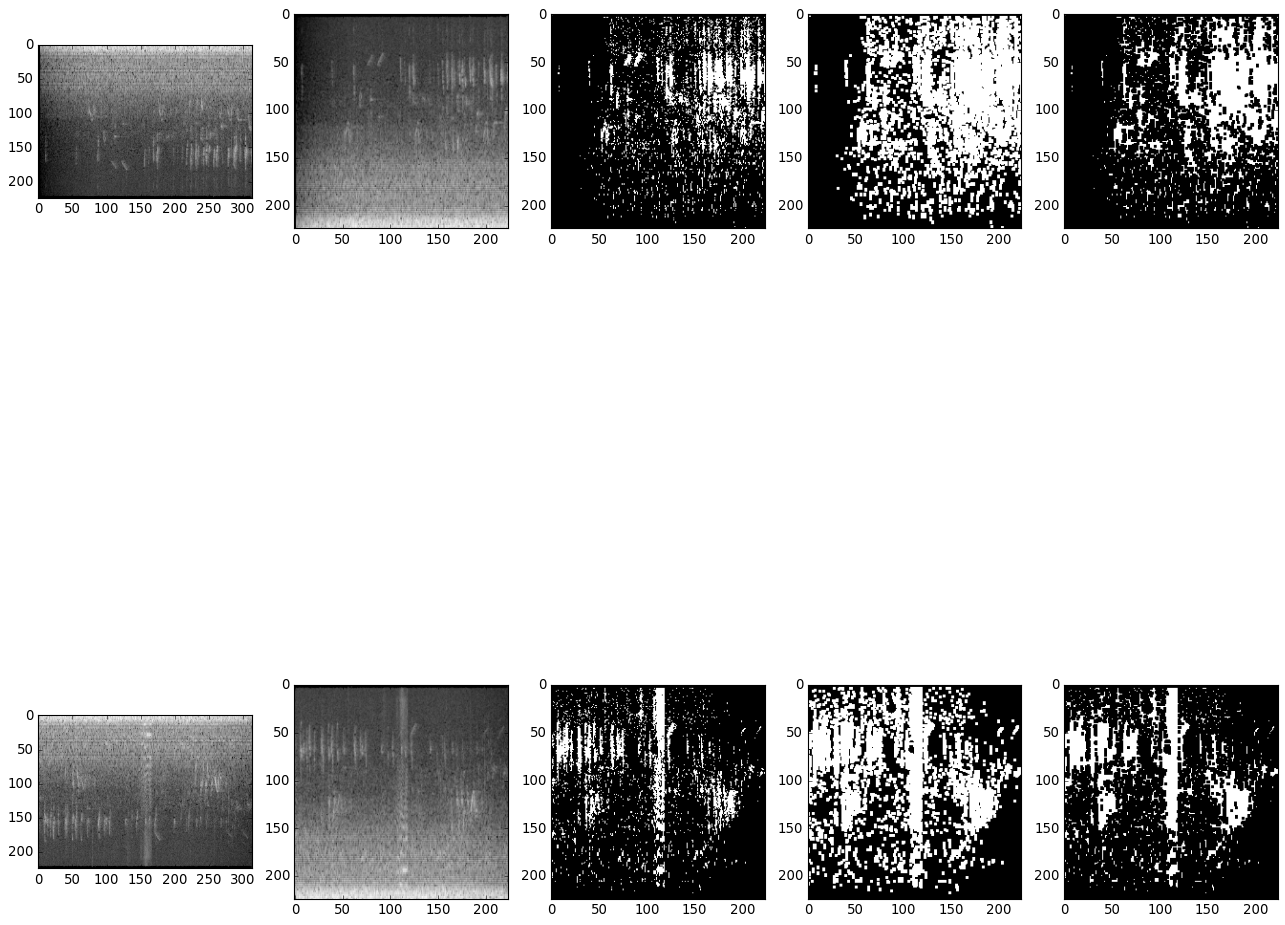

In [836]:
audio_name = f"{PATH_1}/train_audio/afrsil1/XC125458.ogg"

y, sr = sf.read(audio_name, always_2d=True)
y = np.mean(y, 1)
y = crop_or_pad(y)
kernel = np.ones((3,3), np.uint8)

plt.set_cmap(plt.get_cmap("gray"))
plt.style.use('grayscale')
plt.rcParams['figure.facecolor'] = 'white'
print(plt.style.available)

plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plot_idx = 1
nrows = 2
ncols = 5

for index, element in enumerate(y[:-1]):

    X = compute_melspec(element, AudioParams)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = mono_to_color(X)
    X = cv.resize(X, (224, 224))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = median_clipping(X[:,:,0], 5.7)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = cv.dilate(np.float32(X), kernel, iterations=1)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = cv.erode(X, kernel, iterations=1)
    X = X.astype(np.uint8)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    #plt.hist(X.ravel(), bins=256, range=[0, 256])
plt.show()

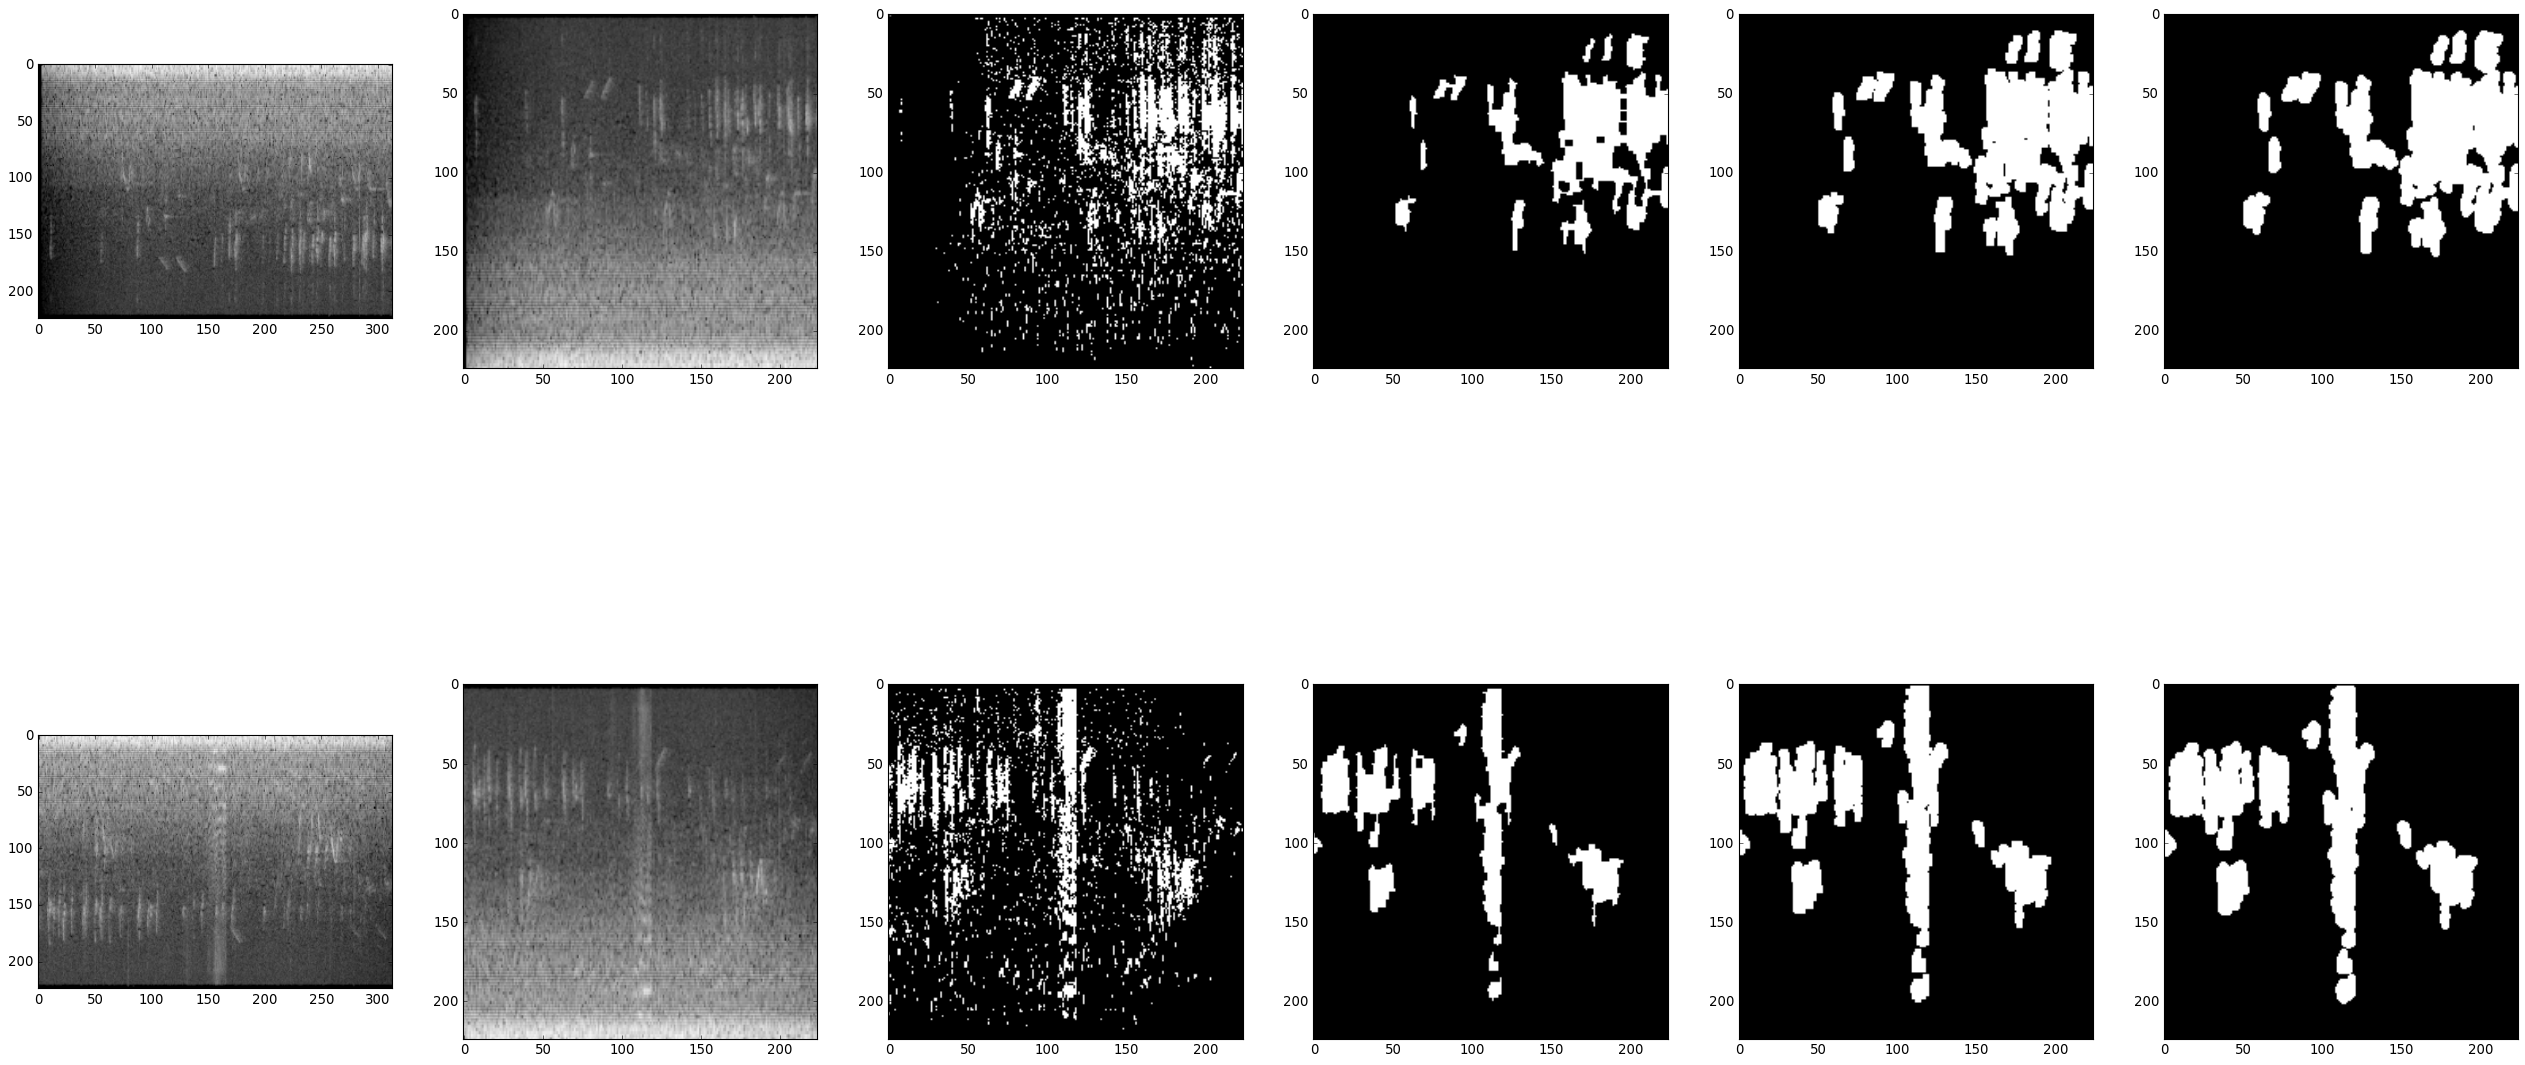

In [837]:
plt.figure(figsize=(40, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plot_idx = 1
nrows = 2
ncols = 6

for index, element in enumerate(y[:-1]):

    X = compute_melspec(element, AudioParams)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = mono_to_color(X)
    X = cv.resize(X, (224, 224))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = median_clipping(X[:,:,0], 5.7)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = morphology.remove_small_objects(X, min_size=32, connectivity=1)
    X = morphology.binary_closing(X, footprint=np.ones((4, 4)))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = morphology.binary_dilation(X, footprint=np.ones((4, 4)))
    X = X.astype(np.uint8)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = filters.median(X, footprint=np.ones((2, 2)))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    #plt.hist(X.ravel(), bins=256, range=[0, 256])
plt.show()

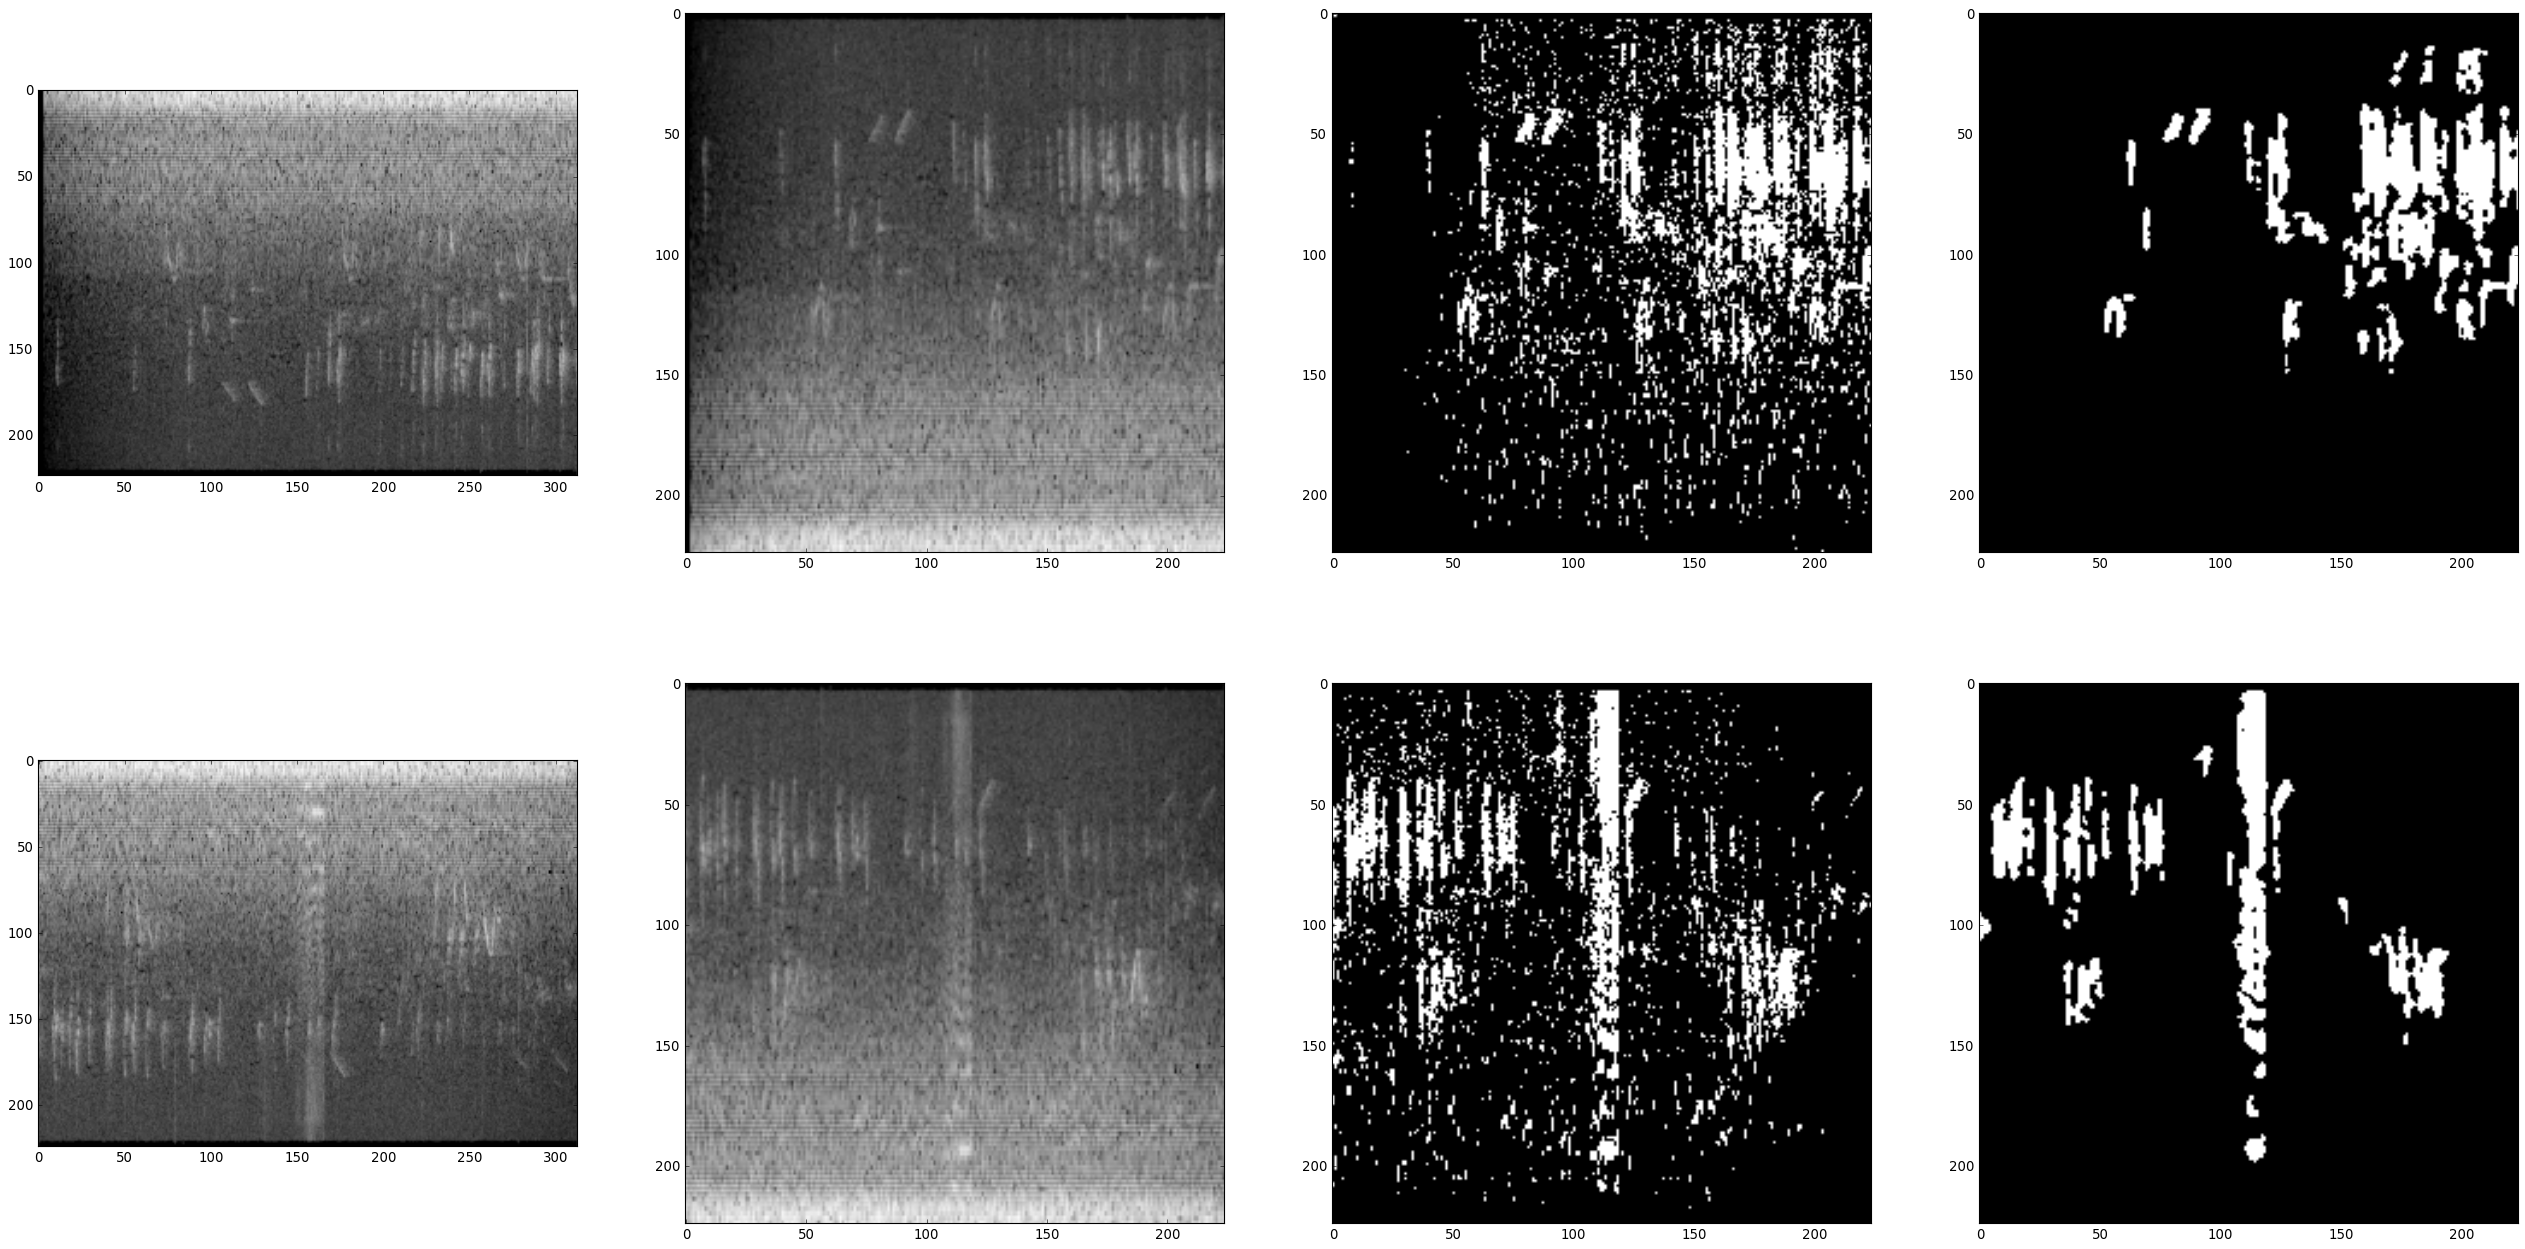

In [838]:
plt.figure(figsize=(40, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plot_idx = 1
nrows = 2
ncols = 4

for index, element in enumerate(y[:-1]):

    X = compute_melspec(element, AudioParams)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = mono_to_color(X)
    X = cv.resize(X, (224, 224))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = median_clipping(X[:,:,0], 5.7)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = morphology.remove_small_objects(X, min_size=32, connectivity=1)
    X = cv.medianBlur(np.float32(X), 3)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    #plt.hist(X.ravel(), bins=256, range=[0, 256])
plt.show()

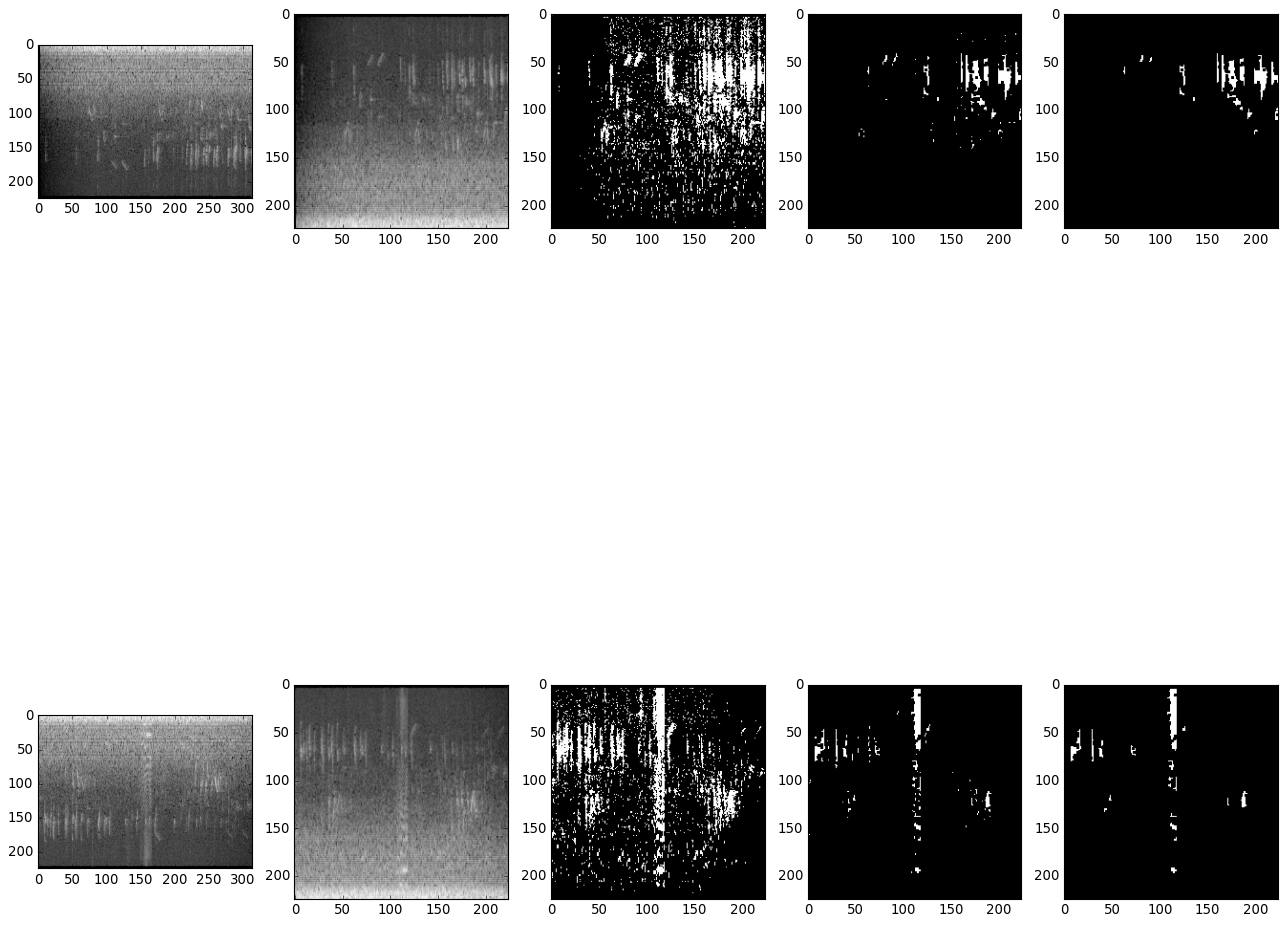

In [839]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plot_idx = 1
nrows = 2
ncols = 5

for index, element in enumerate(y[:-1]):

    X = compute_melspec(element, AudioParams)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = mono_to_color(X)
    X = cv.resize(X, (224, 224))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = median_clipping(X[:,:,0], 5.7)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1


    X = cv.erode(np.float32(X), kernel, iterations=1)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = morphology.remove_small_objects(np.array(X, dtype=bool), min_size=8, connectivity=1)
    X = X.astype(np.uint8)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    #plt.hist(X.ravel(), bins=256, range=[0, 256])
plt.show()

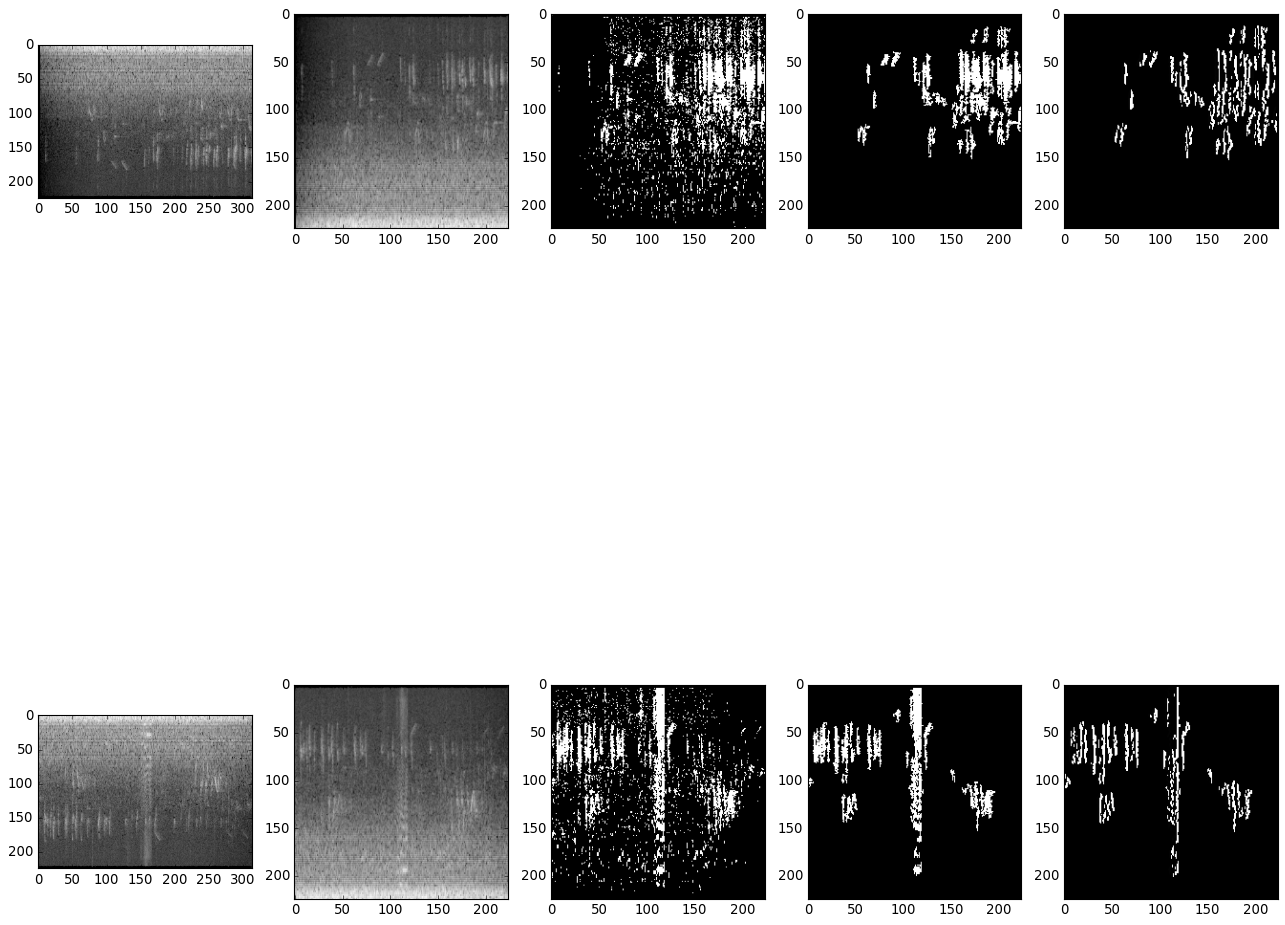

In [840]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plot_idx = 1
nrows = 2
ncols = 5

for index, element in enumerate(y[:-1]):

    X = compute_melspec(element, AudioParams)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = mono_to_color(X)
    X = cv.resize(X, (224, 224))
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = median_clipping(X[:,:,0], 5.7)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1


    X = morphology.remove_small_objects(np.array(X, dtype=bool), min_size=32, connectivity=1)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    X = cv.Sobel(src=np.float32(X), ddepth=cv.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge
    X = X.astype(np.uint8)
    ax = plt.subplot(nrows, ncols, plot_idx)
    plt.imshow(X)
    plot_idx += 1

    #plt.hist(X.ravel(), bins=256, range=[0, 256])
plt.show()

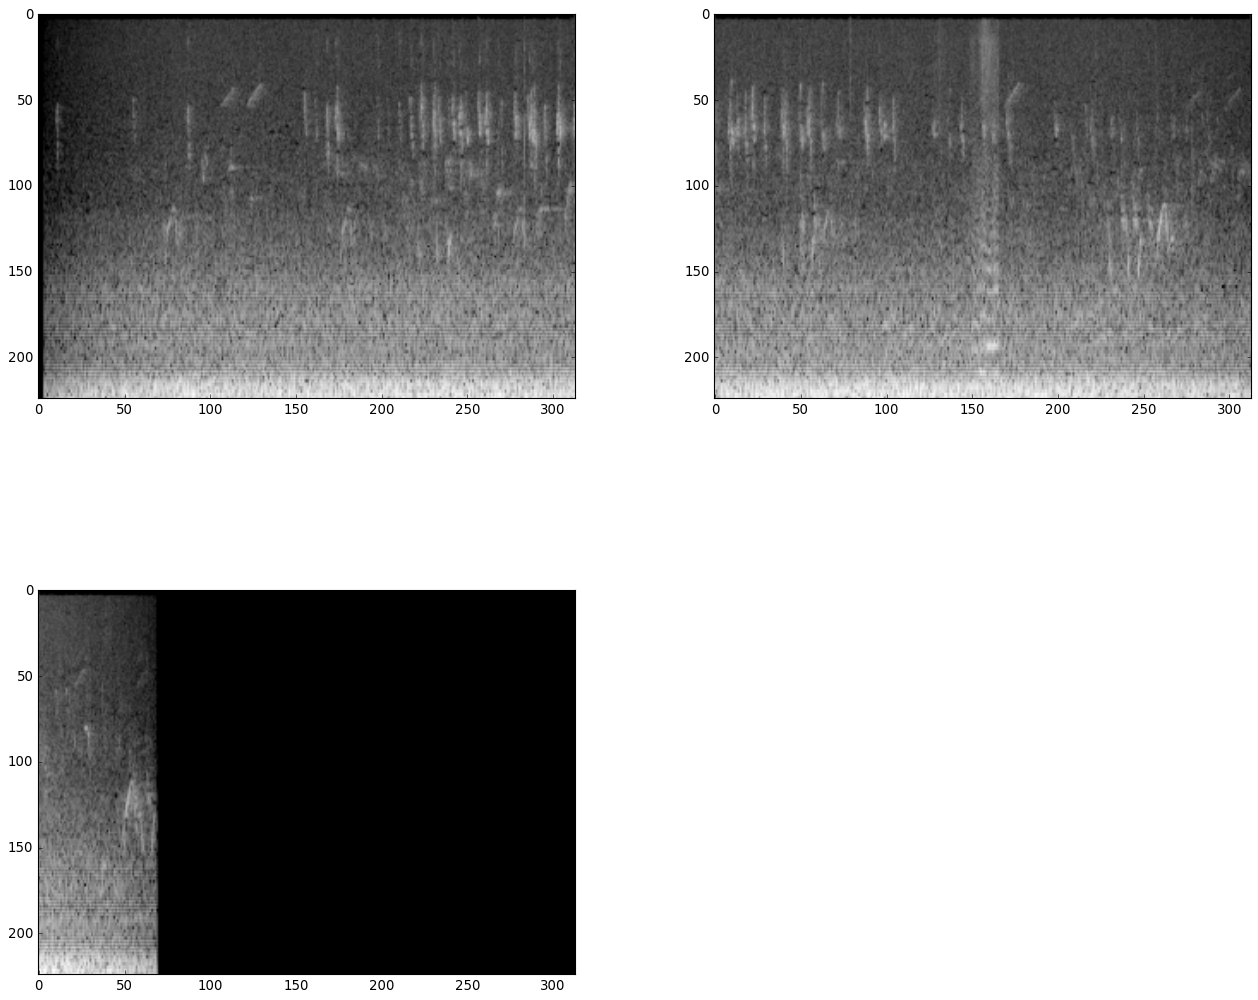

In [841]:
# Example to check if an audio file is correctly split into 5 seconds pieces
audio_name = f"{PATH_1}/train_audio/afrsil1/XC125458.ogg"

y, sr = sf.read(audio_name, always_2d=True)
y = np.mean(y, 1)
y = crop_or_pad(y)

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for index, element in enumerate(y):
    ax = plt.subplot(2, 2, index + 1)
    X = compute_melspec(element, AudioParams)
    X = mono_to_color(X)
    X = X.astype(np.uint8)
    plt.imshow(X)
plt.show()


In [842]:
# Example to validate if a single mel spectrogram can be saved to disk and loaded without loss
# Save
paths = AUDIO_PATH + '/' + train['filename']
paths = paths.values
save_to(paths[0])

# Load
PATH_NAME = f"{PATH_1}/train_images/afrsil1/XC125458_0.npy"
spec = np.load(PATH_NAME)
print(spec.shape)
ret, thresh1 = cv.threshold(spec, 120, 255, cv.THRESH_BINARY +
                                            cv.THRESH_OTSU)

cv.imshow('Otsu Threshold', thresh1)
plt.imshow(spec)

(224, 224, 3)


error: OpenCV(4.5.1) ..\modules\imgproc\src\thresh.cpp:1557: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 16 (CV_8UC3)
